<a href="https://colab.research.google.com/github/EmmanuelFlorencioT/SkinScan-ANN-Module/blob/main/SkinScan_v3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Skin Cancer - Segmentation and Classfication

In [ ]:
import numpy as np
import pandas as pd
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
import os
from sklearn.model_selection import train_test_split
import cv2
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
data_dir = "/content/gdrive/My Drive/dataset/HAM10000_balanced"
subfolders = [f.name for f in os.scandir(data_dir) if f.is_dir()]

## Create a dictionary of subfolders and filenames

The key to this dictionary is the name of each subfolder, or the classes that the HAM10000 dataset has.

The values for each element in the directory is a list of all filenames in the corresponding directory.

In [ ]:
data = {}
for subfolder in subfolders:
    subfolder_path = os.path.join(data_dir, subfolder)
    data[subfolder] = os.listdir(subfolder_path)

In [ ]:
data['vasc'][0]

'augmented_image_11_5.jpg'

## Split the `data` into training and testing dictionaries

In [ ]:
train_data = {}
test_data = {}
for subfolder in subfolders:
    train_data[subfolder], test_data[subfolder] = train_test_split(data[subfolder], test_size=0.2)

In [ ]:
print("class = [train, test, total]\n")
for clss in subfolders:
  info = []
  info.append(len(train_data[clss]))
  info.append(len(test_data[clss]))
  info.append(len(train_data[clss]) + len(test_data[clss]))
  print(f"{clss}\t = {info}")

class = [train, test, total]

vasc	 = [940, 236, 1176]
akiec	 = [811, 203, 1014]
bcc	 = [849, 213, 1062]
df	 = [952, 238, 1190]
bkl	 = [880, 220, 1100]
mel	 = [891, 223, 1114]
nv	 = [960, 240, 1200]


------

## Create a figure with 7 subplots

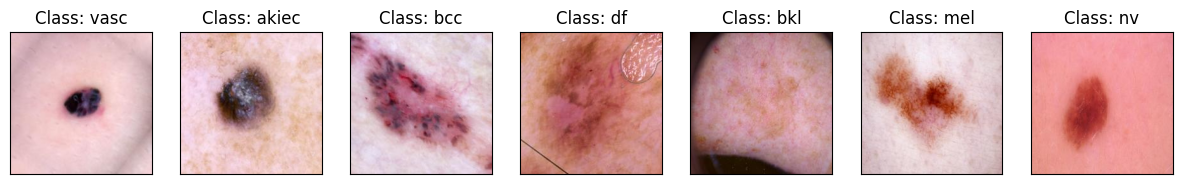

In [ ]:
fig, axs = plt.subplots(1, 7, figsize=(15, 3))

i = 0
# Loop through the training dataset
for clss in subfolders:
  #Take off the ticks in the axes
  plt.setp(axs, xticks=(), yticks=())

  img_path = os.path.join(data_dir, clss, data[clss][0])
  img = mpimg.imread(img_path)
  axs[i].imshow(img)
  axs[i].set_title(f"Class: {clss}")
  i += 1

# Show the figure
plt.show()

## CNN

### Model Architecture Proposal

Suggested model architecture:
```
Input (224x224x3)
|
|-- Conv2D (3x3, 32 filters, stride 2, relu)
|-- BatchNormalization
|-- Conv2D (3x3, 64 filters, relu)
|-- BatchNormalization
|-- Depthwise Separable Convolution (3x3, 128 filters, relu)
|-- BatchNormalization
|
|-- Residual Block 1 (64 filters)
|   |-- Conv2D (1x1, 64 filters, relu)
|   |-- BatchNormalization
|   |-- Conv2D (3x3, 64 filters, relu)
|   |-- BatchNormalization
|   |-- Conv2D (1x1, 128 filters, stride 2, linear)
|   |-- BatchNormalization
|
|-- Residual Block 2 (128 filters)
|   |-- Conv2D (1x1, 128 filters, relu)
|   |-- BatchNormalization
|   |-- Conv2D (3x3, 128 filters, relu)
|   |-- BatchNormalization
|   |-- Conv2D (1x1, 256 filters, stride 2, linear)
|   |-- BatchNormalization
|
|-- Residual Block 3 (256 filters)
|   |-- Conv2D (1x1, 256 filters, relu)
|   |-- BatchNormalization
|   |-- Conv2D (3x3, 256 filters, relu)
|   |-- BatchNormalization
|   |-- Conv2D (1x1, 512 filters, linear)
|   |-- BatchNormalization
|
|-- Global Average Pooling
|-- Dense (Number of classes, softmax activation)
```

### Define Model Architecture

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, DepthwiseConv2D, GlobalAveragePooling2D, Dense, Add

In [ ]:
def depthwise_separable_block(x, filters, stride):
    # Depthwise Separable Convolution
    x = DepthwiseConv2D((3, 3), padding='same', strides=stride, activation='relu')(x)
    x = BatchNormalization()(x)

    # Pointwise Convolution
    x = Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    return x

In [ ]:
def residual_block(x, filters, stride):
    # Shortcut
    shortcut = x

    # First convolution
    x = Conv2D(filters, (1, 1), strides=stride, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    # Second convolution
    x = Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    # Third convolution
    x = Conv2D(filters * 2, (1, 1), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    # Shortcut connection
    shortcut = Conv2D(filters * 2, (1, 1), strides=stride, padding='same', activation=None)(shortcut)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = tf.keras.activations.relu(x)

    return x

In [ ]:
'''
Model creation using Keras Functional API to declare a complex model.
'''

# Input
input_tensor = Input(shape=(224, 224, 3))

# Initial Convolutional Block
x = Conv2D(32, (3, 3), strides=(2,2), padding='same', activation='relu')(input_tensor)
x = x = BatchNormalization()(x)

x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)

x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = x = BatchNormalization()(x)

# Residual Blocks
x = residual_block(x, 64, 1)
x = residual_block(x, 128, 2)
x = residual_block(x, 256, 2)

# Global Average Pooling
x = GlobalAveragePooling2D()(x)

# Fully Connected Layer
output_tensor = Dense(7, activation='softmax')(x)

# Delete the current model if there one that already exists
if 'model' in globals(): del model

# Create Model
model = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)

# Display Model Summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 112, 112, 64)         18496     ['batch_normalization[0][0

### Extract the dataset

In [ ]:
def one_hot_encode_labels(images, labels):
    labels = tf.one_hot(labels, depth=7)
    return images, labels

In [ ]:
# from keras.utils import image_dataset_from_directory
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(224, 224),
  batch_size=16
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(224, 224),
  batch_size=16
)

# Extract the correct class names for the Confusion Matrix
dataset_class_names = train_ds.class_names

Found 7856 files belonging to 7 classes.
Using 6285 files for training.
Found 7856 files belonging to 7 classes.
Using 1571 files for validation.


In [ ]:
dataset_class_names

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [ ]:
# Extract one batch from the training dataset
one_element = train_ds.take(1)

print(one_element)

# Iterate through the batch to extract the iterators
for images, labels in one_element:
  # Now, 'images' and 'labels' contain the data for one batch
  print(f"Shape of images: {images.shape}") # 32 colored images of 224x224
  print(f"Shape of labels: {labels.shape}")

  print(f"Info of labels: {labels}")

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Shape of images: (16, 224, 224, 3)
Shape of labels: (16,)
Info of labels: [4 2 5 4 1 6 6 2 4 2 4 6 3 4 6 5]


In [ ]:
# Preprocessing data
train_ds = train_ds.map(one_hot_encode_labels)
val_ds = val_ds.map(one_hot_encode_labels)

In [ ]:
from keras.optimizers import Adam

opt = Adam(learning_rate=0.0015)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
393/393 [==============================] - 816s 2s/step - loss: 1.6644 - accuracy: 0.3667 - val_loss: 2.0542 - val_accuracy: 0.3743
Epoch 2/50
393/393 [==============================] - 61s 156ms/step - loss: 1.4509 - accuracy: 0.4527 - val_loss: 1.5463 - val_accuracy: 0.3934
Epoch 3/50
393/393 [==============================] - 63s 160ms/step - loss: 1.3267 - accuracy: 0.4961 - val_loss: 1.3926 - val_accuracy: 0.4984
Epoch 4/50
393/393 [==============================] - 62s 157ms/step - loss: 1.2203 - accuracy: 0.5341 - val_loss: 2.2601 - val_accuracy: 0.3959
Epoch 5/50
393/393 [==============================] - 62s 158ms/step - loss: 1.1667 - accuracy: 0.5519 - val_loss: 2.2379 - val_accuracy: 0.3997
Epoch 6/50
393/393 [==============================] - 62s 156ms/step - loss: 1.1151 - accuracy: 0.5718 - val_loss: 1.8358 - val_accuracy: 0.4354
Epoch 7/50
393/393 [==============================] - 62s 158ms/step - loss: 1.0783 - accuracy: 0.5895 - val_loss: 1.1553 - val_accu

In [ ]:
model.save('/content/gdrive/My Drive/dataset/my_model_ss_v3_2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


-----

### Evaluate the model

#### Training Plots

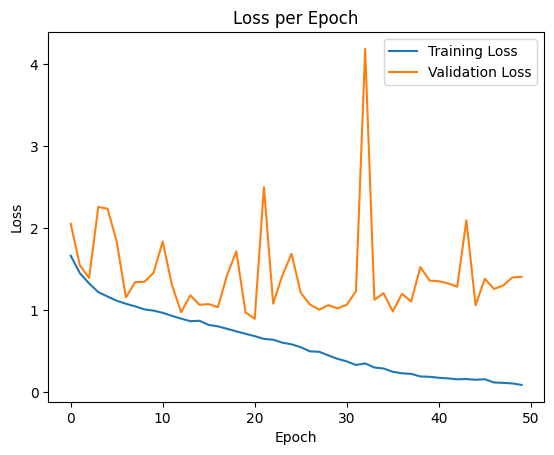

In [ ]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.show()

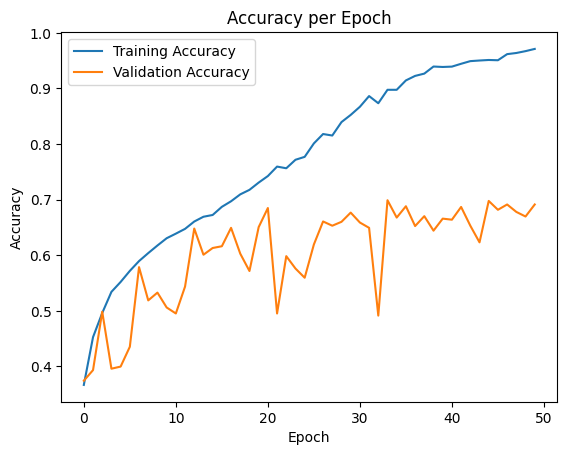

In [ ]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.show()

#### Confusion matrix

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
# Get the predicted classes for the test set
y_true = []
y_pred = []

for images, labels in val_ds:
  predictions = model.predict(images)
  predicted_labels = np.argmax(predictions, axis=1)
  true_labels = np.argmax(labels, axis=1)

  y_true.extend(true_labels)
  y_pred.extend(predicted_labels)

1/1 [==============================] - 0s 22ms/step


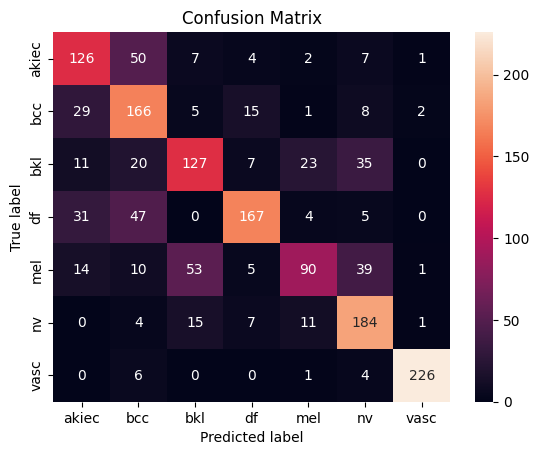

In [ ]:
# Calculate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn
sns.heatmap(confusion_mtx, annot=True, fmt='d',
            xticklabels=dataset_class_names,
            yticklabels=dataset_class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

#### Classify the image into a specific category

In [ ]:
import tensorflow as tf
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

In [ ]:
lesion = 'bcc'

# Load the image to be analyzed into memory
if lesion == 'bcc':
  image = cv2.imread('/content/gdrive/My Drive/dataset/HAM10000_images/bcc/ISIC_0024331.jpg')
elif lesion == 'df':
  image = cv2.imread('/content/gdrive/My Drive/dataset/HAM10000_images/df/ISIC_0024845.jpg')

# Load the pre-trained model previously saved
# model = tf.keras.models.load_model('/content/gdrive/My Drive/dataset/my_model_ss_v4.h5')

In [ ]:
cv2_imshow(image)

In [ ]:
# Preprocess the image in the same way as during the training.
image = cv2.resize(image, (224, 224))
image = image.astype('float32')
image /= 255.0
image = np.expand_dims(image, axis=0)

# Uses the model to make a prediction on the preprocessed image
predictions = model.predict(image)
print(predictions)

In [ ]:
predictions.shape

In [ ]:
# Interprets the prediction output and displays the object detection result in the image
predicted_class_index = np.argmax(predictions, axis=-1)[0] # obtain the index of the class with the highest probability
print(dataset_class_names);
print(f'Predicted Index: {predicted_class_index}')
print(f'Level of Confidence: {predictions[0][predicted_class_index] * 100}')
predicted_class_name = dataset_class_names[predicted_class_index] # get the name of the class
plt.imshow(cv2.cvtColor(image[0], cv2.COLOR_BGR2RGB))
plt.title(f'Predicted Class = {predicted_class_name}')
plt.axis("off")
plt.show()